In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [163]:
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

y = train_df['yield']
train_df.drop(columns=['yield'], inplace=True)

train_df.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds'],
      dtype='object')

<Axes: xlabel='0'>

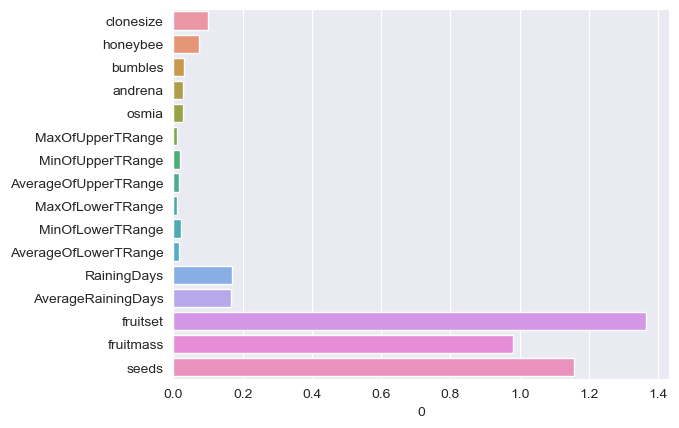

In [164]:
from sklearn.feature_selection import mutual_info_regression

values = mutual_info_regression(train_df, y)

mutual_info_df = pd.DataFrame(data=np.reshape(values, (1, 16)), columns=train_df.columns)

sns.barplot(x=mutual_info_df.loc[0], y=mutual_info_df.columns)

## 1.0 Feature Engineering

### 1.1 Variable Introduction

From our mutual regression score, we can see that seeds, fruitmass, and fruitset have high MI score in relation to the target variable. So let's try to create new features from those present features.

<Axes: xlabel='0'>

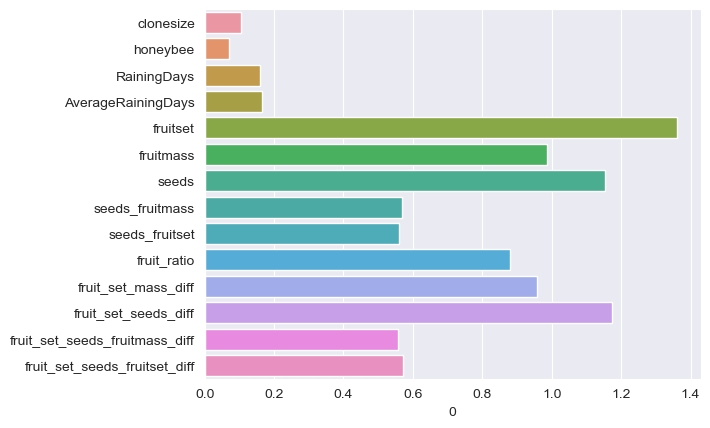

In [165]:

feature_engineered_df = train_df.copy()
feature_engineered_df['seeds_fruitmass'] = feature_engineered_df['seeds'] / feature_engineered_df['fruitmass']
feature_engineered_df['seeds_fruitset'] = feature_engineered_df['seeds'] / feature_engineered_df['fruitset']
feature_engineered_df['fruit_ratio'] = feature_engineered_df['fruitset'] / feature_engineered_df['fruitmass']
feature_engineered_df['fruit_set_mass_diff'] = feature_engineered_df['fruitset'] - feature_engineered_df['fruitmass']
feature_engineered_df['fruit_set_seeds_diff'] = feature_engineered_df['fruitset'] - feature_engineered_df['seeds']
feature_engineered_df['fruit_set_seeds_fruitmass_diff'] = feature_engineered_df['fruitset'] - feature_engineered_df[
    'seeds_fruitmass']
feature_engineered_df['fruit_set_seeds_fruitset_diff'] = feature_engineered_df['fruitset'] - feature_engineered_df[
    'seeds_fruitset']
feature_engineered_df.drop(
    columns=['MinOfLowerTRange', 'MaxOfLowerTRange', 'AverageOfLowerTRange', 'MinOfUpperTRange', 'MaxOfUpperTRange',
             'AverageOfUpperTRange', 'bumbles', 'andrena', 'osmia'], inplace=True)

values = mutual_info_regression(feature_engineered_df, y)
engineered_mutual_info_df = pd.DataFrame(
    data=np.reshape(values, (1, len(feature_engineered_df.columns))), columns=feature_engineered_df.columns)

sns.barplot(y=engineered_mutual_info_df.columns, x=engineered_mutual_info_df.loc[0])

### 1.2 Scaling Data

Using the standard scaler from sklearn, we can normalize the data across the dataset

In [166]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(feature_engineered_df)

scaled_data_df = pd.DataFrame(data=scaled_data, columns=feature_engineered_df.columns)

feature_engineered_df = scaled_data_df.copy()

feature_engineered_df.head()

,clonesize,honeybee,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,seeds_fruitmass,seeds_fruitset,fruit_ratio,fruit_set_mass_diff,fruit_set_seeds_diff,fruit_set_seeds_fruitmass_diff,fruit_set_seeds_fruitset_diff
0,0.802929,0.306073,0.458012,0.401611,-1.044938,-0.783260,-0.918905,-0.827890,0.711869,-1.127733,-1.167222,0.915303,0.816321,-0.719044
1,0.802929,0.306073,0.458012,0.401611,-0.777454,-0.661588,-0.572230,-0.165933,0.661205,-0.728779,-0.798499,0.567607,0.152212,-0.665247
2,-1.092448,-0.385238,0.458012,0.401611,0.674659,0.656157,0.540029,0.156178,-0.584802,0.592583,0.620131,-0.536775,-0.144410,0.588201
3,-1.092448,-0.385238,0.458012,0.401611,0.850087,0.852832,0.819312,0.453414,-0.512854,0.696002,0.758263,-0.817633,-0.441502,0.519344
4,0.802929,0.306073,0.458012,0.401611,1.034261,1.285628,1.071598,0.288152,-0.493266,0.578662,0.702492,-1.070858,-0.270665,0.502450


## 2.0 EDA (Exploratory Data Analysis)

We will be exploring the data, and visualizing how different models perform on the now scaled data, along with new features introduced.

LinearRegression
BayesianRidge
Ridge
Lasso


C:\Users\flyin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+06, tolerance: 2.035e+06
  model = cd_fast.enet_coordinate_descent(


LinearSVR
LassoCV
SGDRegressor
AdaBoostRegressor
BaggingRegressor
ExtraTreesRegressor
GradientBoostingRegressor
RandomForestRegressor


<Axes: xlabel='Score', ylabel='Regressor'>

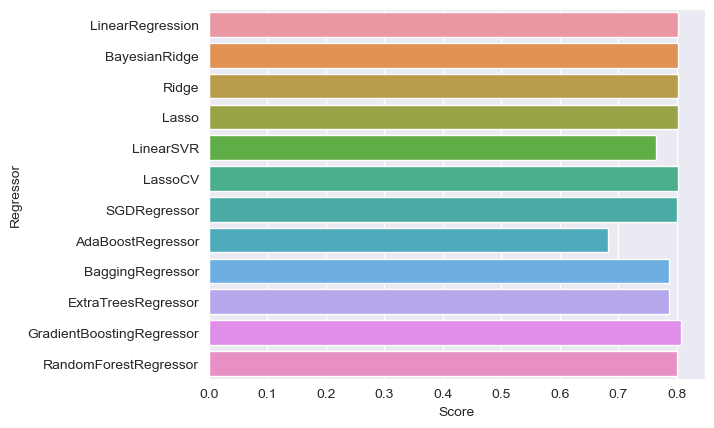

In [177]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, LassoCV, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
    RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR, SVR

###############################################
## Accumulating list of regressors being used
###############################################
regressors = [
    LinearRegression(),
    BayesianRidge(),
    Ridge(),
    Lasso(),
    LinearSVR(),
    LassoCV(),
    SGDRegressor(),
    AdaBoostRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor(),
    RandomForestRegressor()
]

##############################################
## Columns used in the statistics dataframe
##############################################
statistics_columns = ['Regressor', 'Score', 'MAE']

##############################################
## Dataframe holding all the regressor data
##############################################
regressor_df = pd.DataFrame(columns=statistics_columns)

##############################
## Splitting training data
##############################
train_x, test_x, train_y, test_y = train_test_split(feature_engineered_df, y)

# Iterate through all the regressors, accumulating their score and mean squared error
for each_regressor in regressors:
    regressor_name = each_regressor.__class__.__name__
    print(regressor_name)
    each_regressor.fit(train_x, train_y)
    predicted = each_regressor.predict(test_x)
    mae = mean_squared_error(predicted, test_y)
    score = each_regressor.score(test_x, test_y)
    new_regressor_df = pd.DataFrame(data={'Regressor': [regressor_name], 'Score': [score], 'MAE': [mae]},
                                    columns=statistics_columns)
    regressor_df = pd.concat([regressor_df, new_regressor_df])

sns.barplot(y=regressor_df['Regressor'], x=regressor_df['Score'])

<Axes: xlabel='MAE', ylabel='Regressor'>

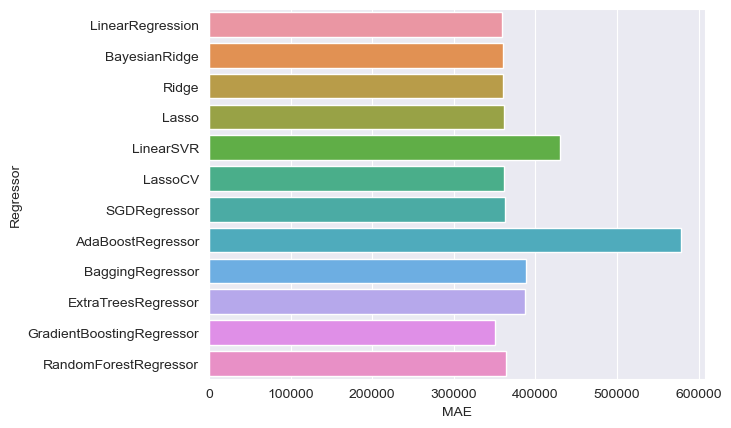

In [178]:
sns.barplot(y=regressor_df['Regressor'], x=regressor_df['MAE'])

## 3.0 Model with testing data

In [169]:
ratioed_testing_data = test_df.copy()

ratioed_testing_data['seeds_fruitmass'] = ratioed_testing_data['seeds'] / ratioed_testing_data['fruitmass']
ratioed_testing_data['seeds_fruitset'] = ratioed_testing_data['seeds'] / ratioed_testing_data['fruitset']
ratioed_testing_data['fruit_ratio'] = ratioed_testing_data['fruitset'] / ratioed_testing_data['fruitmass']
ratioed_testing_data['fruit_set_mass_diff'] = ratioed_testing_data['fruitset'] - ratioed_testing_data['fruitmass']
ratioed_testing_data['fruit_set_seeds_diff'] = ratioed_testing_data['fruitset'] - ratioed_testing_data['seeds']
ratioed_testing_data['fruit_set_seeds_fruitmass_diff'] = ratioed_testing_data['fruitset'] - ratioed_testing_data[
    'seeds_fruitmass']
ratioed_testing_data['fruit_set_seeds_fruitset_diff'] = ratioed_testing_data['fruitset'] - ratioed_testing_data[
    'seeds_fruitset']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_testing_data = scaler.fit_transform(ratioed_testing_data)

scaled_testing_data_df = pd.DataFrame(data=scaled_testing_data, columns=ratioed_testing_data.columns)

ratioed_testing_data = scaled_testing_data_df.copy()

ratioed_testing_data.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,...,fruitset,fruitmass,seeds,seeds_fruitmass,seeds_fruitset,fruit_ratio,fruit_set_mass_diff,fruit_set_seeds_diff,fruit_set_seeds_fruitmass_diff,fruit_set_seeds_fruitset_diff
0,0.789503,-0.363088,-0.606503,-1.628845,-2.453506,0.414398,0.414768,0.420044,0.414636,0.414374,...,-1.371318,-1.032509,-1.179639,-1.046096,1.140788,-1.540796,-1.536828,1.174550,1.030408,-1.148020
1,-1.106867,-0.363088,-0.606503,1.745905,0.262907,1.353982,1.351365,1.348482,1.351655,1.352424,...,-0.184207,-0.093898,0.176782,0.640529,0.550300,-0.183648,-0.246182,-0.183390,-0.651736,-0.547094
2,-1.106867,-0.363088,-0.606503,0.935965,0.262907,0.414398,0.414768,0.420044,0.414636,0.414374,...,1.091922,1.098780,0.970547,0.372087,-0.752804,0.869362,0.978288,-0.967047,-0.354225,0.760198
3,0.789503,0.277932,1.565100,-0.751410,0.262907,0.414398,0.414768,0.420044,0.414636,0.414374,...,-0.920904,-0.634191,-0.751366,-0.673240,0.736128,-1.041281,-1.084561,0.747228,0.662363,-0.741299
4,2.685873,0.918953,-0.606503,-1.628845,-2.453506,1.353982,1.351365,1.348482,1.351655,1.352424,...,-1.884969,-1.551449,-1.636527,-1.293277,1.760904,-2.093876,-1.995195,1.629799,1.270027,-1.768816


In [170]:
test_gradient_boost = GradientBoostingRegressor()
test_gradient_boost.fit(feature_engineered_df, y)

predictions = test_gradient_boost.predict(ratioed_testing_data)

ids = pd.read_csv('test.csv')['id']

predictions_columns = ['id', 'yield']

predictions_df = pd.DataFrame(columns=[predictions_columns[-1]], data=predictions)

pd.concat([ids, predictions_df], axis=1)

predictions_df = pd.DataFrame(columns=predictions_columns, data=pd.concat([ids, predictions_df], axis=1))

predictions_df.shape

predictions_df.to_csv('submission.csv', index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AverageOfLowerTRange
- AverageOfUpperTRange
- MaxOfLowerTRange
- MaxOfUpperTRange
- MinOfLowerTRange
- ...
